In [1]:
import os
import sys
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime

sys.path.append(os.path.join('feature_viz_additoinal_files'))

from config import *
from helper import *
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None 

price_data_df = collecting_data(START_DATE, END_DATE, DATA_OPEN_LOC, DATA_CLOSE_LOC, DATA_HIGH_LOC, DATA_LOW_LOC, DATA_VOL_LOC, DATA_DIV_LOC)
relative_df = get_relative(price_data_df)
risk_free_rate_list = get_risk_free_rate(START_DATE, END_DATE)
risk_free_rate = float(risk_free_rate_list.mean())

positions = create_stat(price_data_df, relative_df, risk_free_rate)

[*********************100%***********************]  1 of 1 completed


In [2]:
# collect statistics from momentum strategy
stocks_types = GROUP_LABELS.keys()

results_dict = {}
results_dict['date'] = []
for index, inner_dict in positions.items():
    add_date_ind = True
    for stocks_type in stocks_types:
        
        if stocks_type not in results_dict:
            results_dict[stocks_type] = {}

        for inner_key in inner_dict[stocks_type].keys():
            
            if 'sharpe_ratio' in inner_key or \
               'open_p' in inner_key or \
               'volume_p' in inner_key or \
               'prices_flunc_p' in inner_key:

                if 'sharpe_ratio' == inner_key or 'open_p' ==inner_key or inner_key=='volume_p' or inner_key=='prices_flunc_p':
                    continue
                    
                if inner_key in results_dict[stocks_type]:
                    results_dict[stocks_type][inner_key].append(inner_dict[stocks_type][inner_key][0])
                else:
                    results_dict[stocks_type][inner_key] = [inner_dict[stocks_type][inner_key][0]]

                if add_date_ind:
                    results_dict['date'].append(inner_dict['date'])
                
                add_date_ind = False
                
with open(DATA_ML_VIZ_LOC, 'wb') as handle:
    pickle.dump(results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

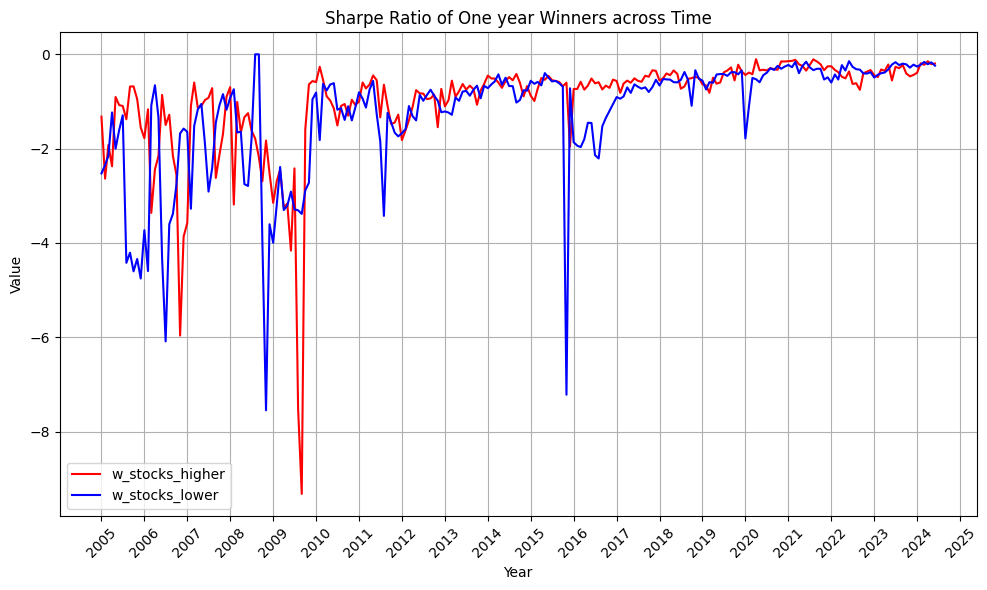

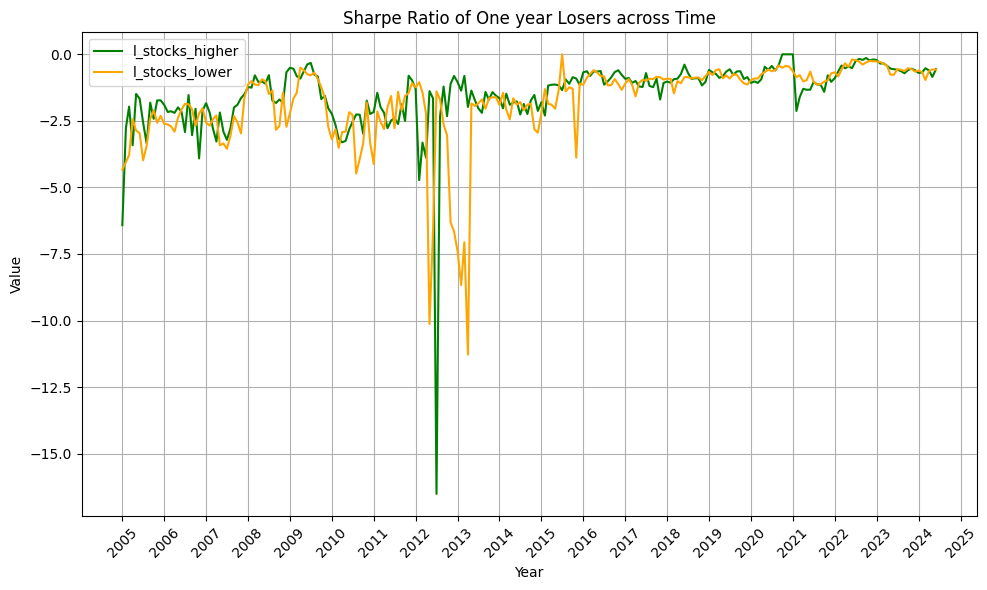

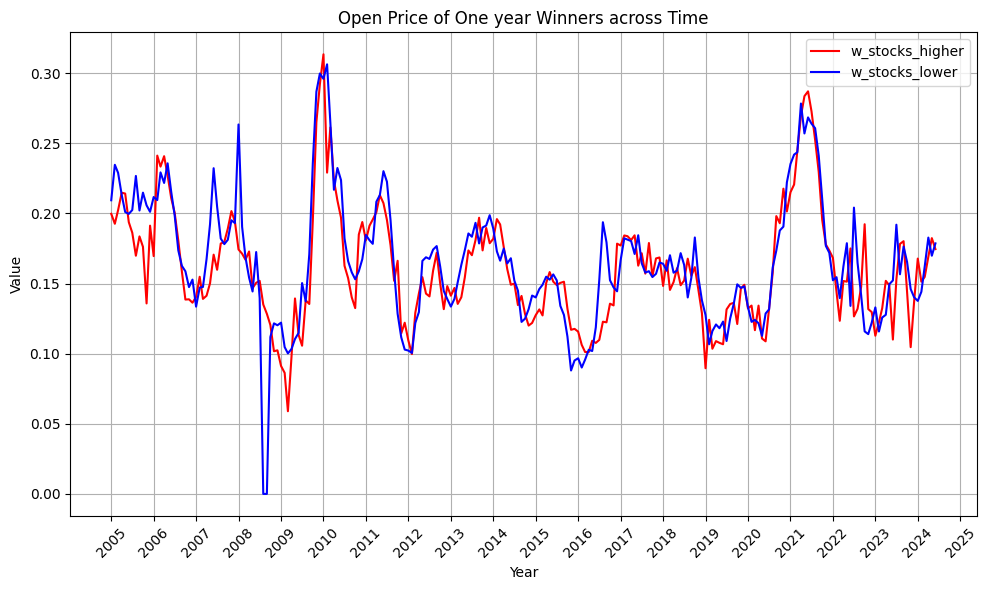

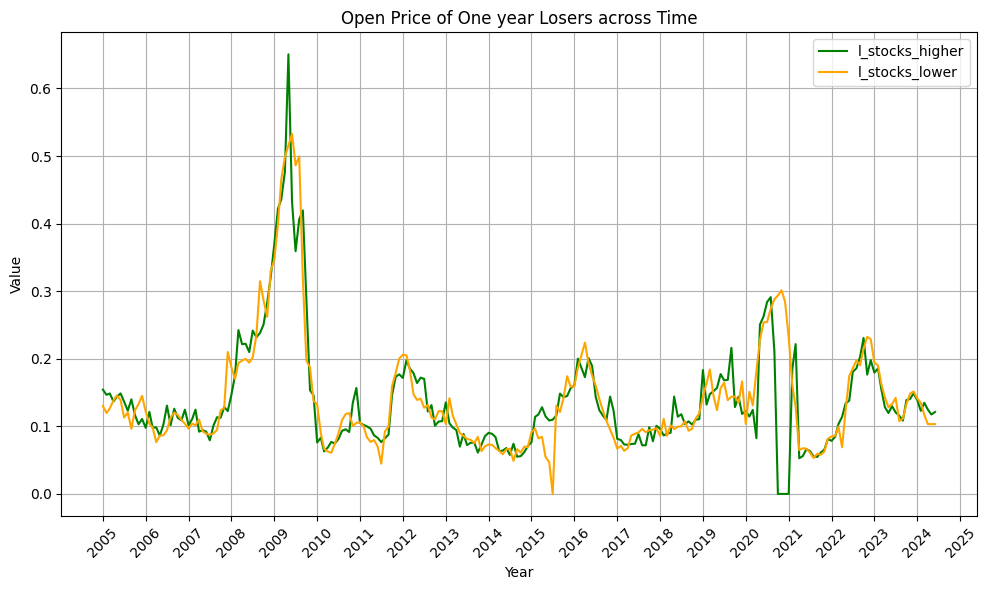

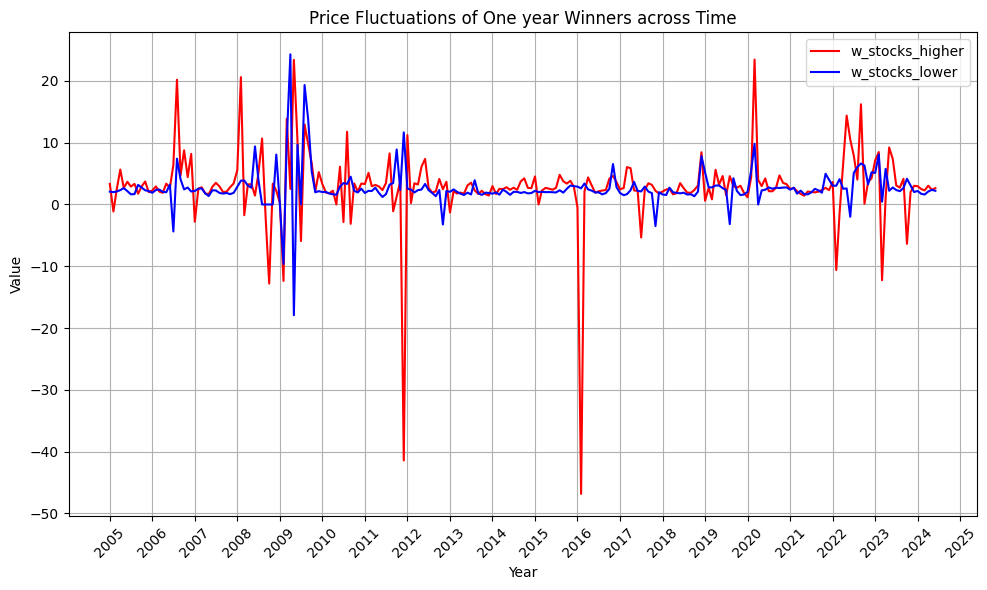

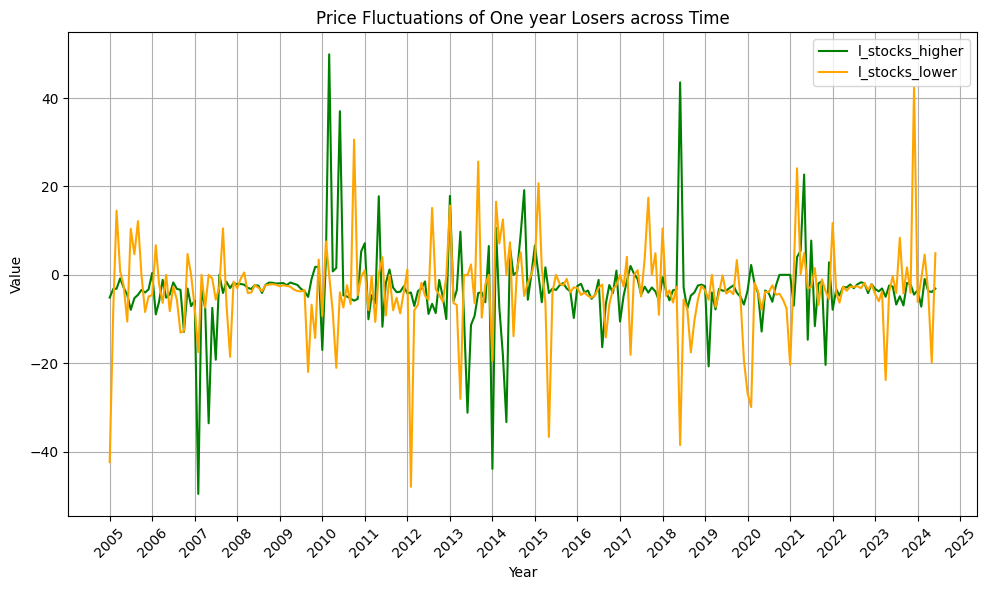

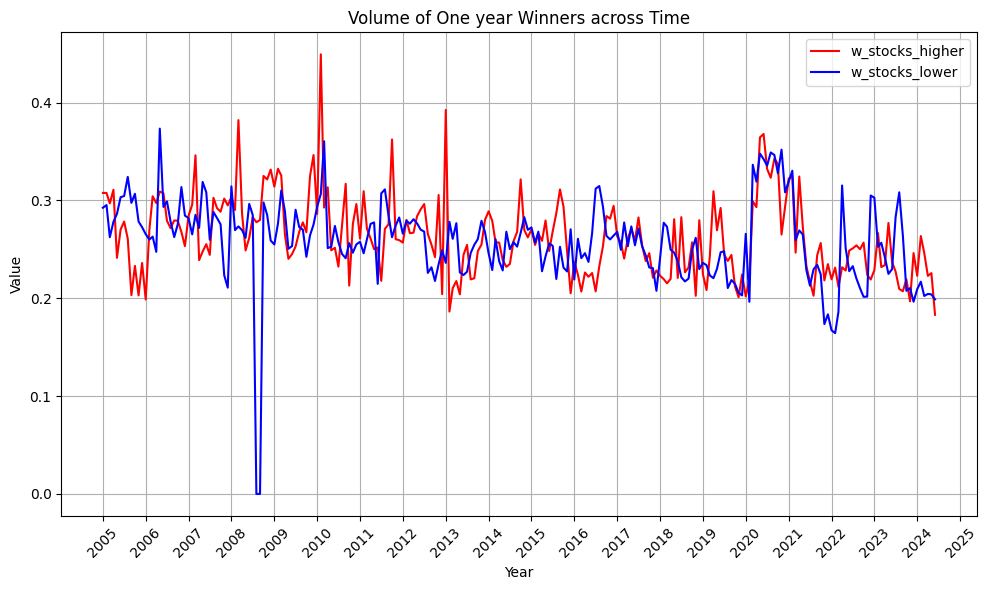

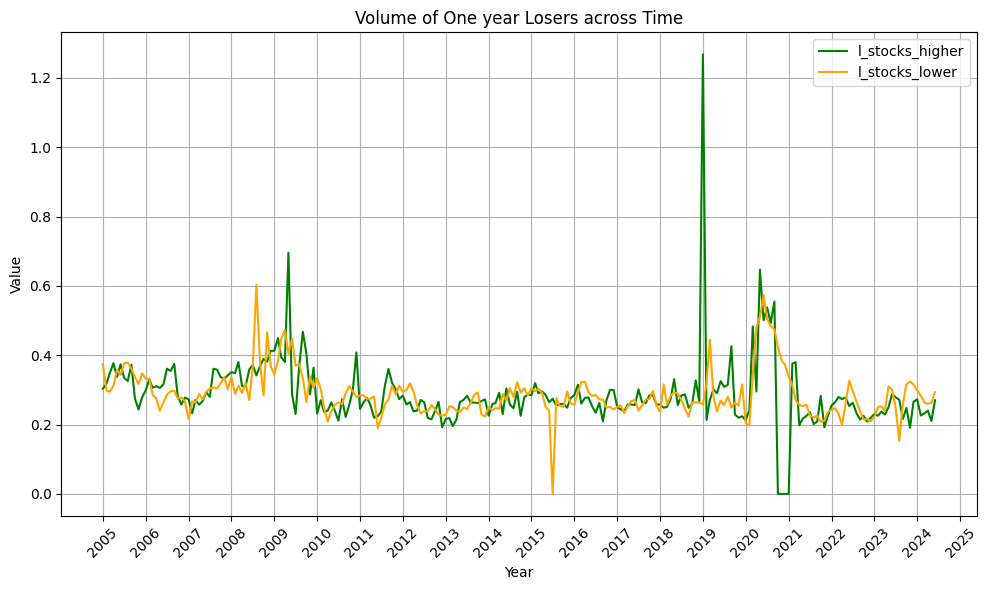

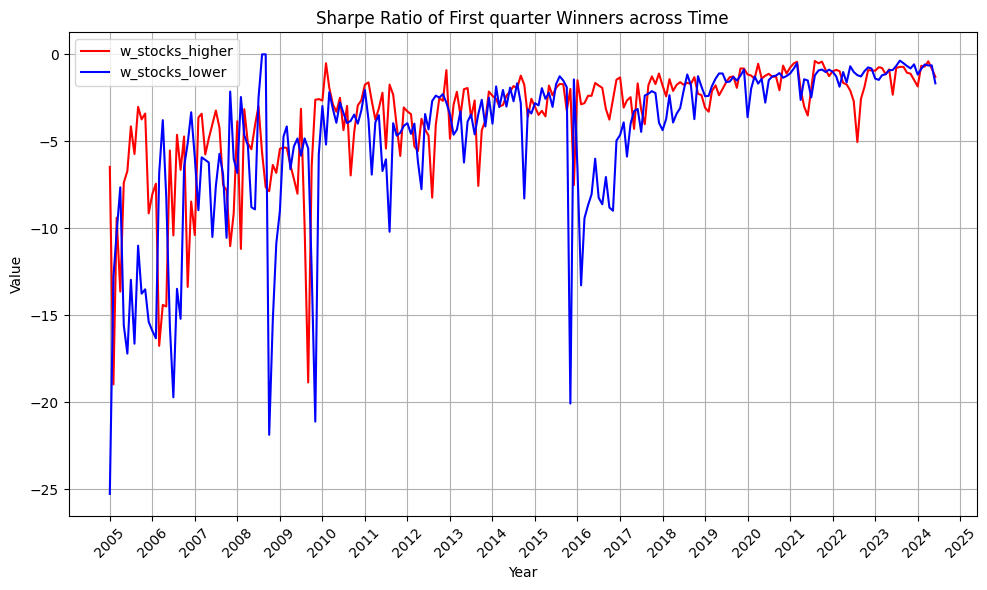

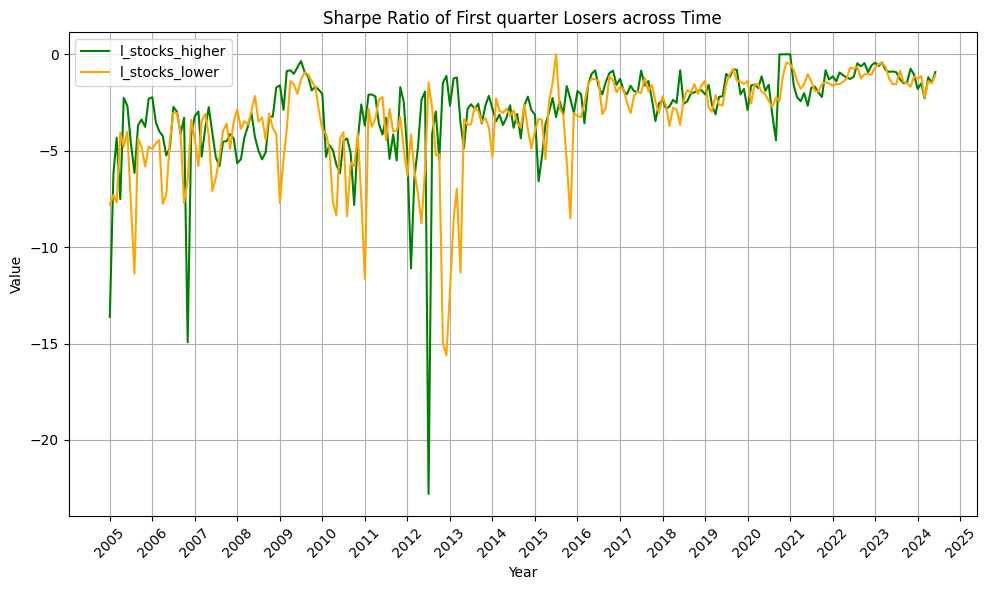

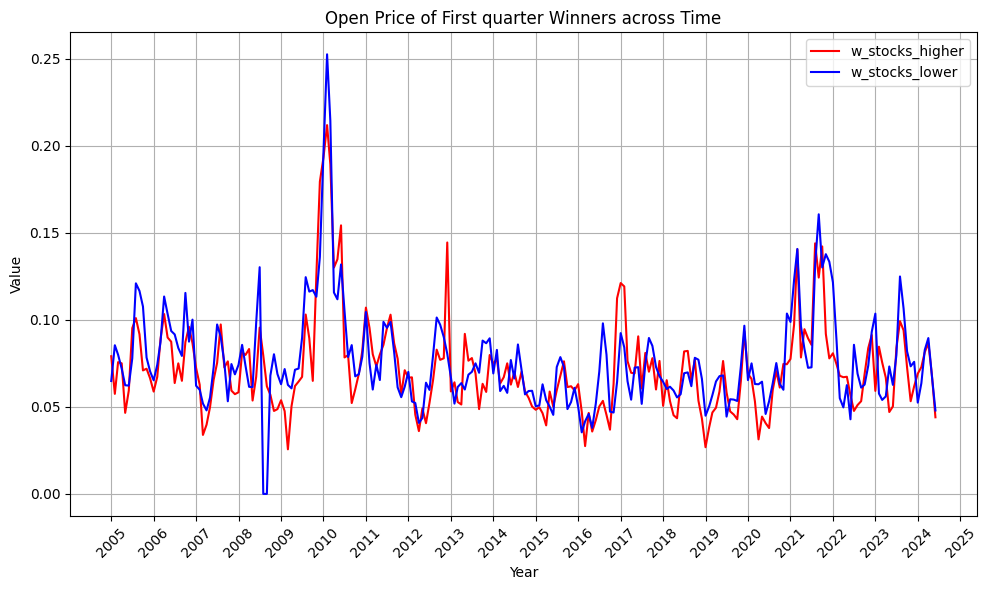

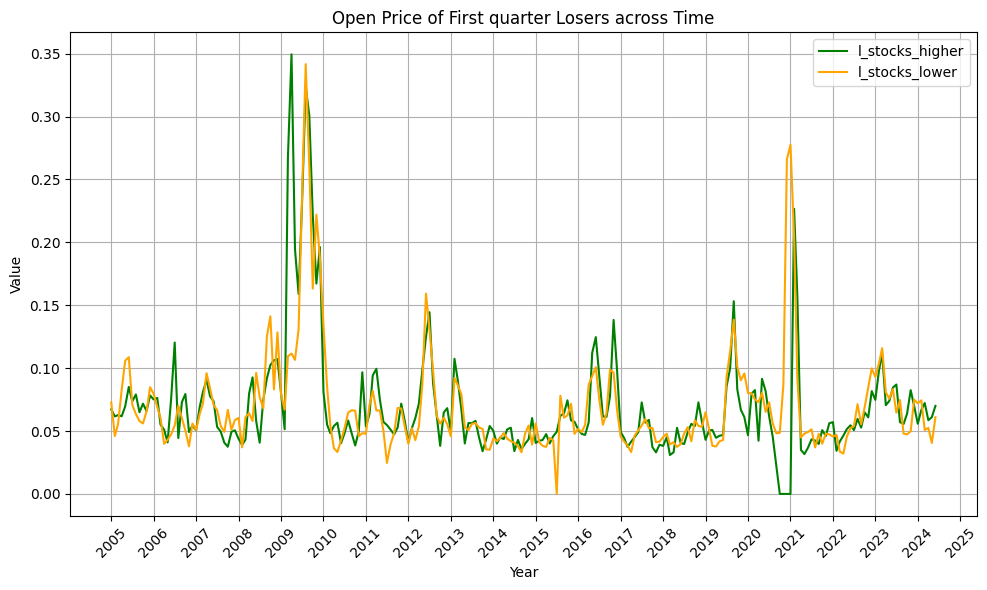

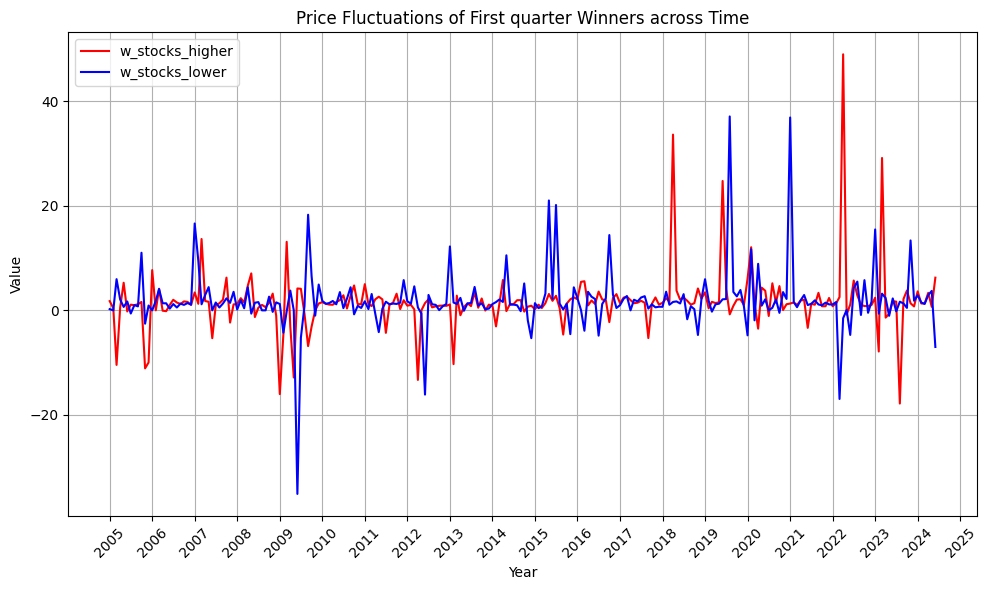

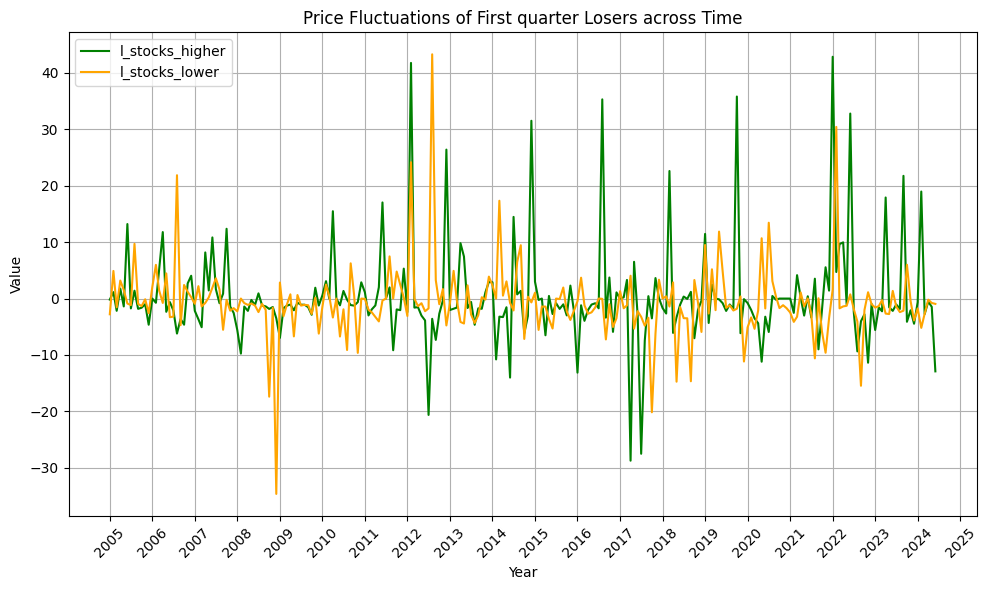

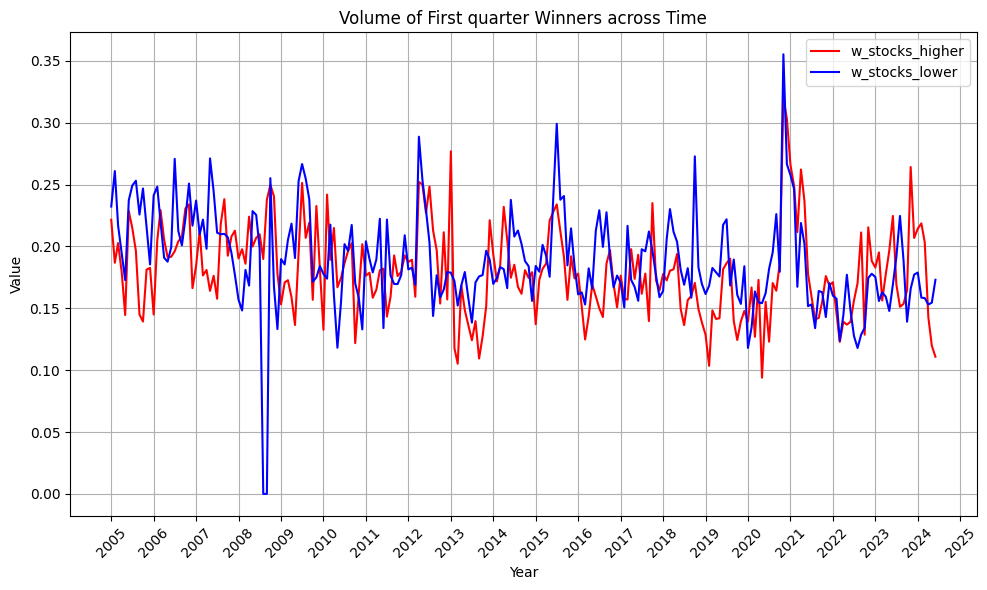

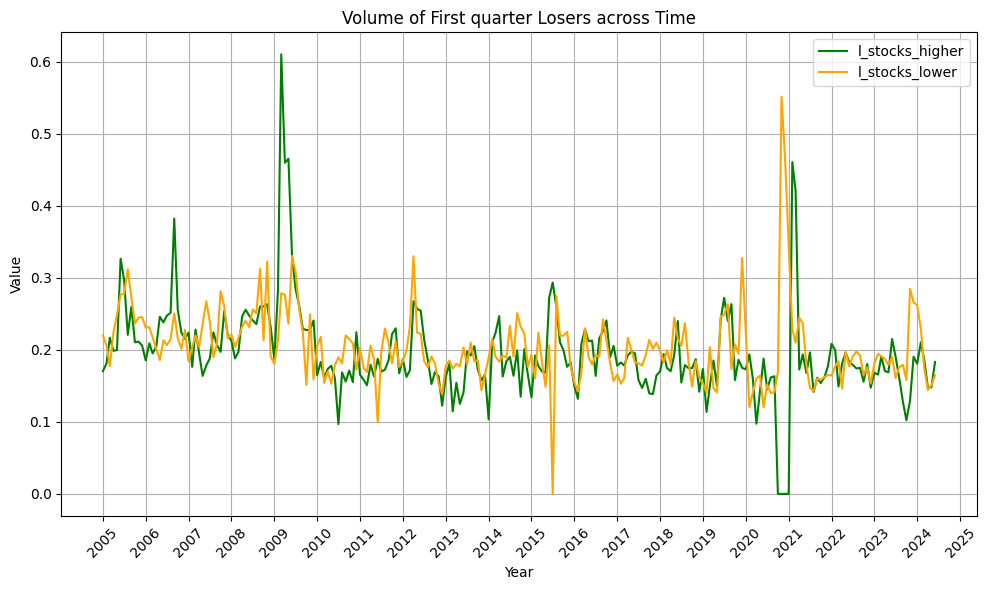

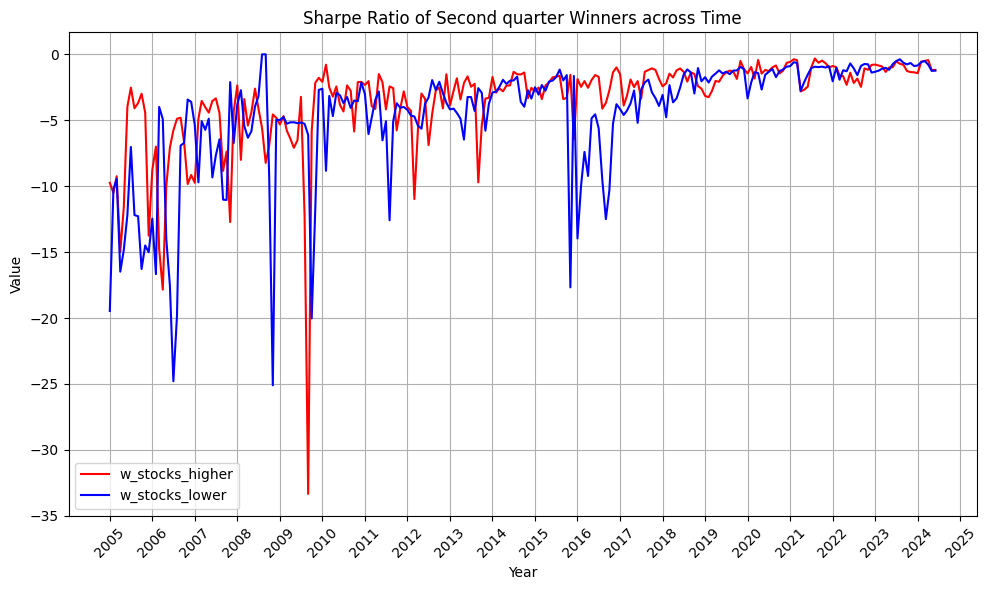

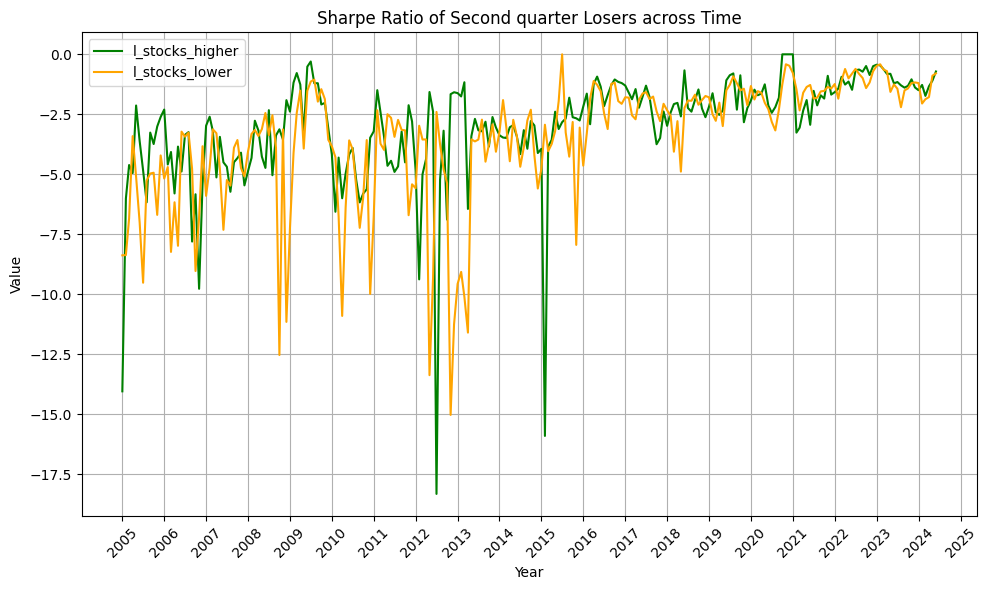

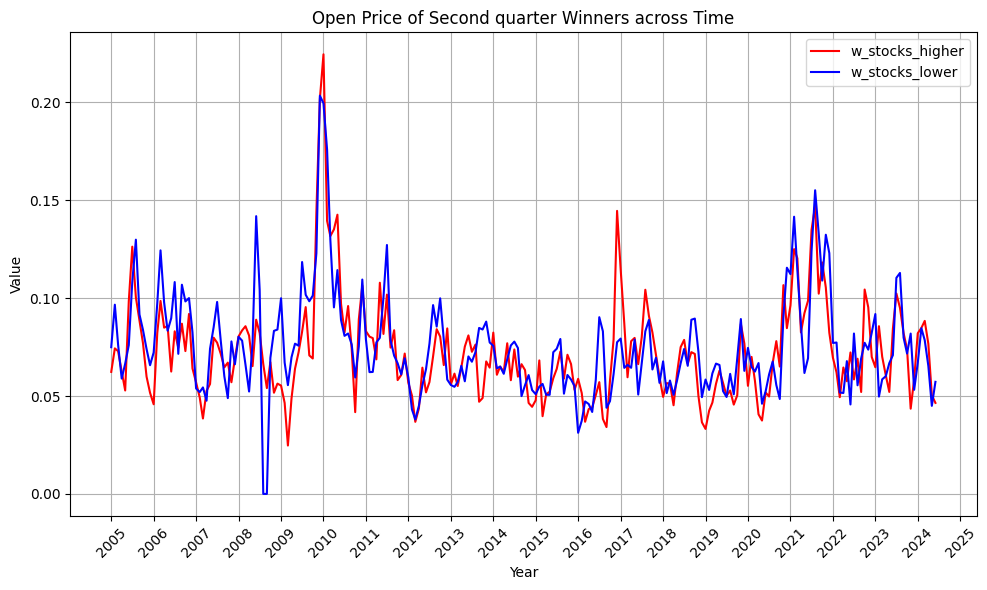

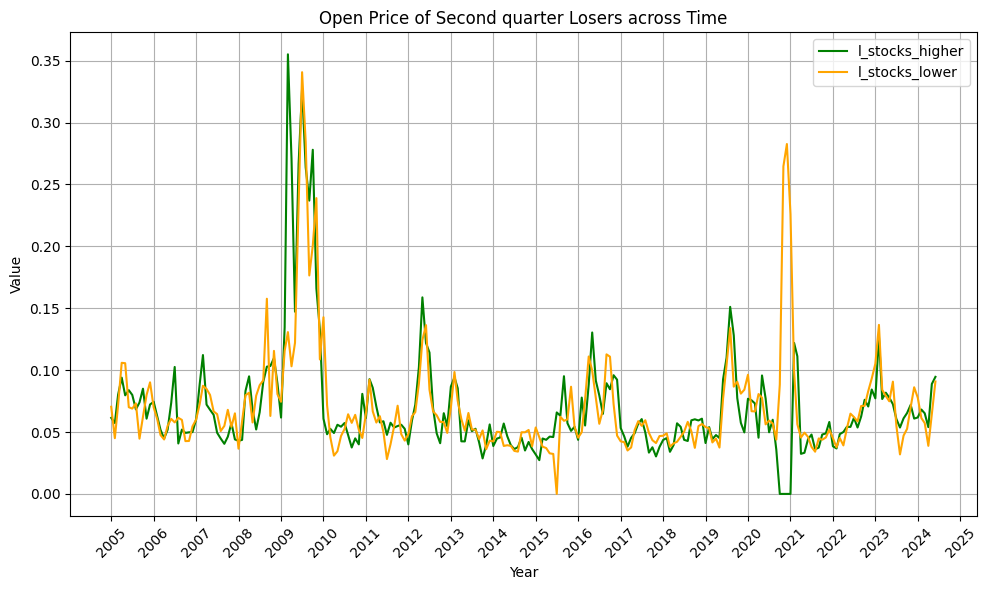

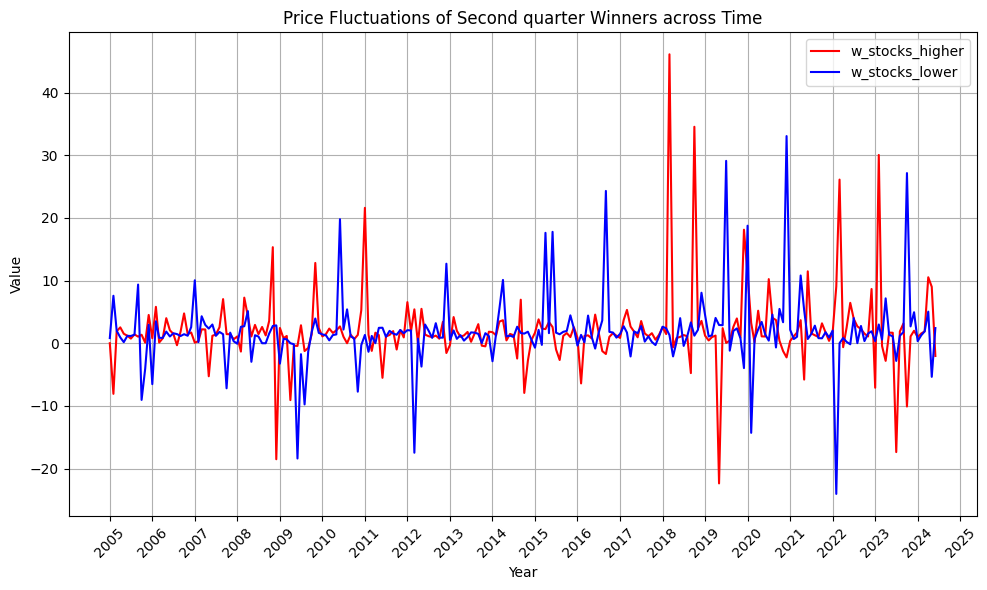

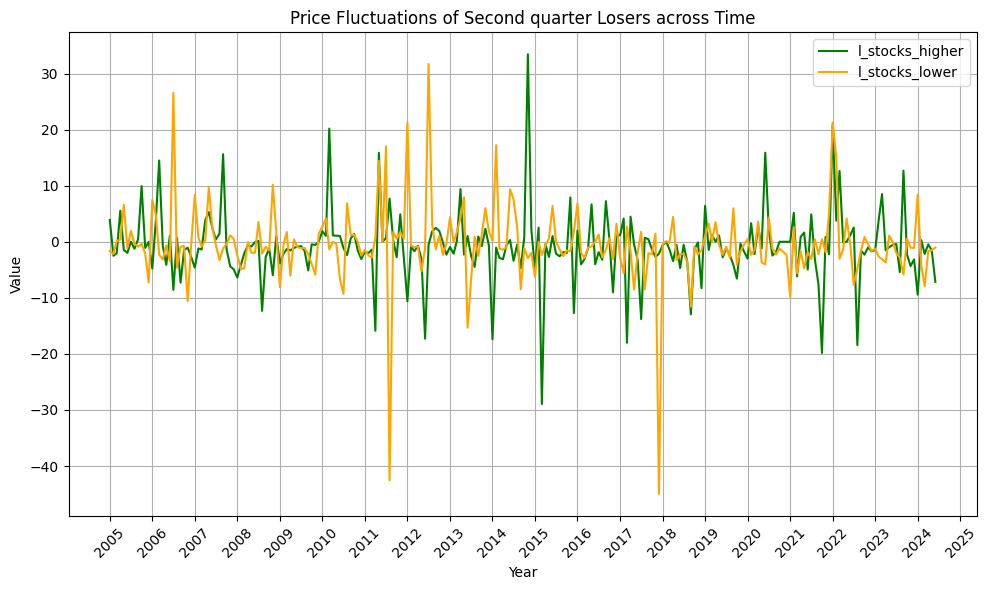

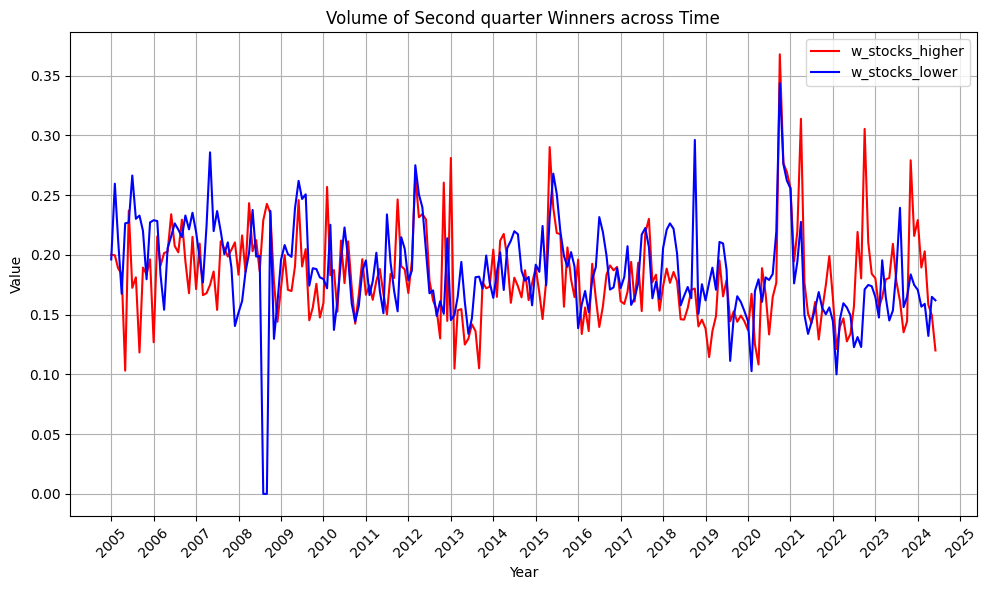

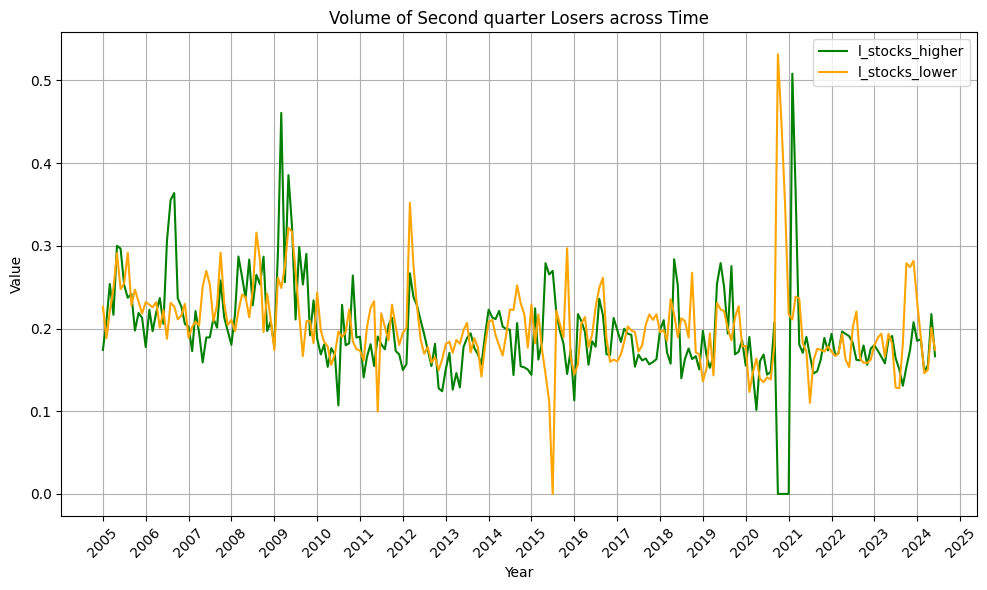

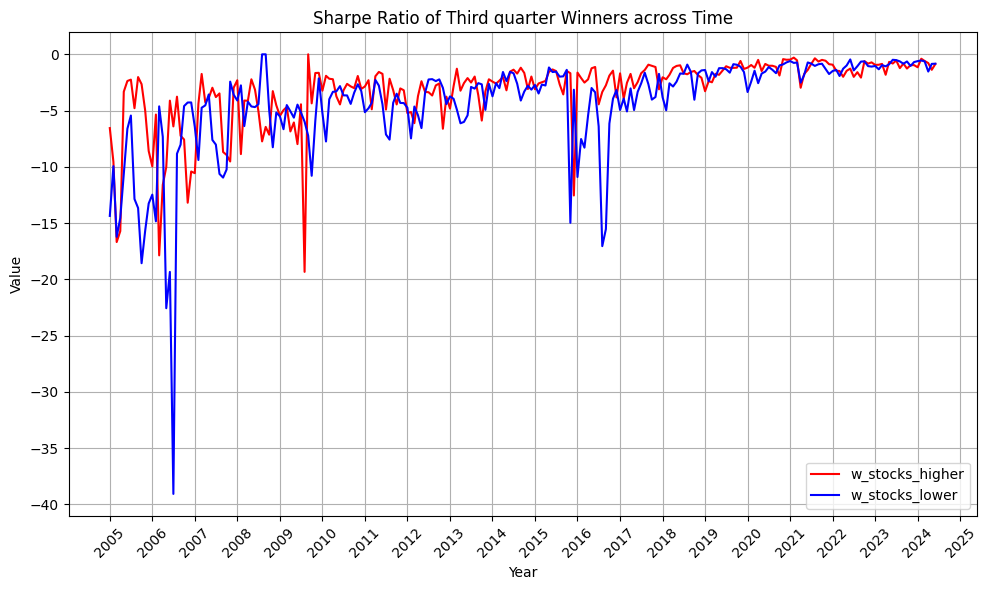

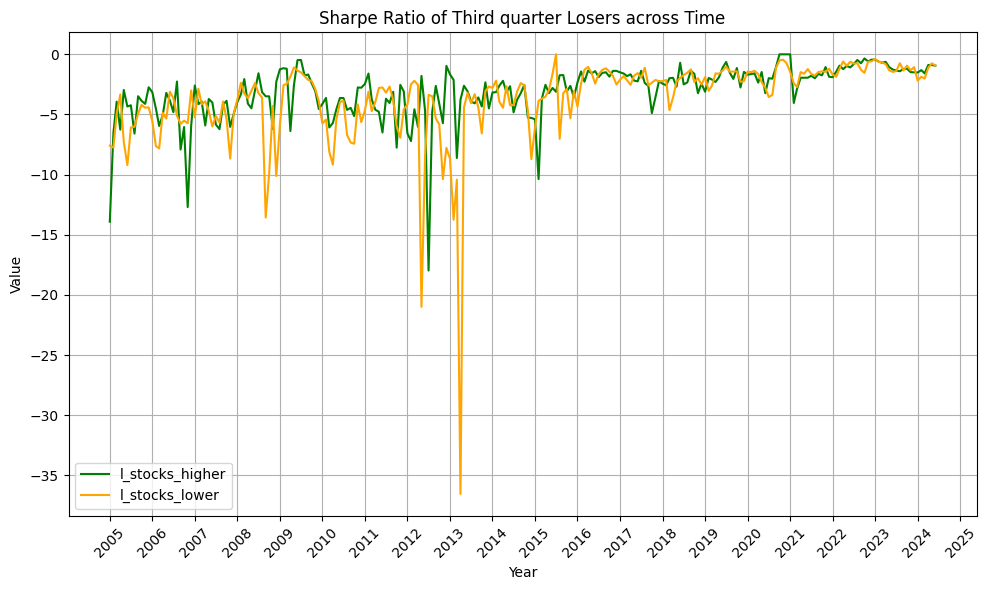

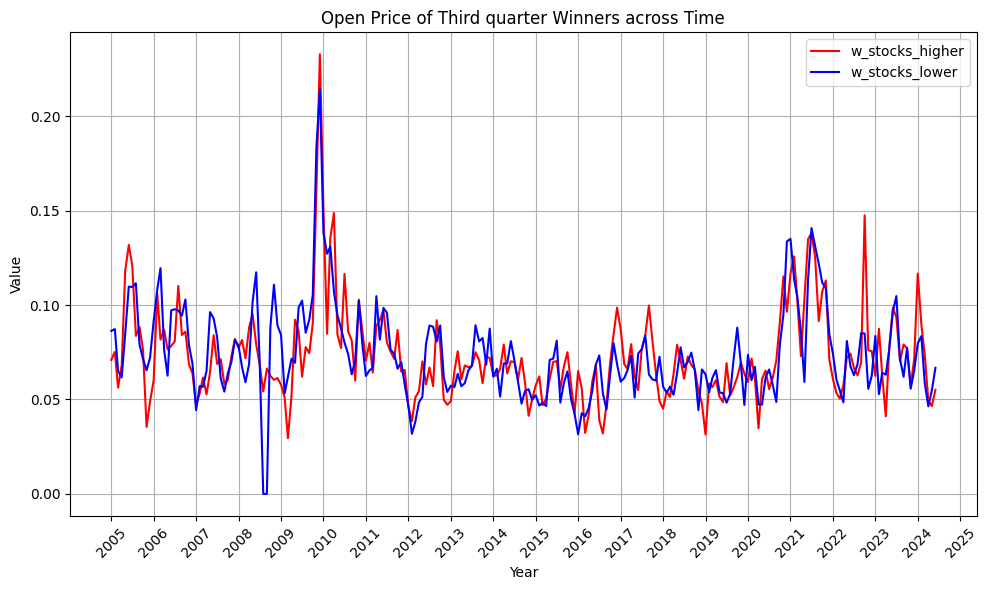

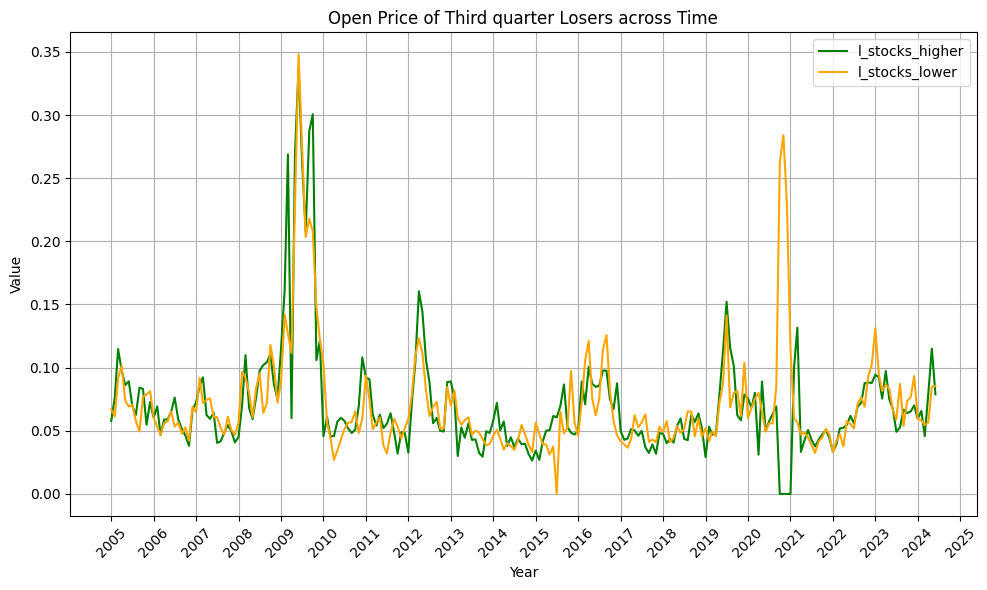

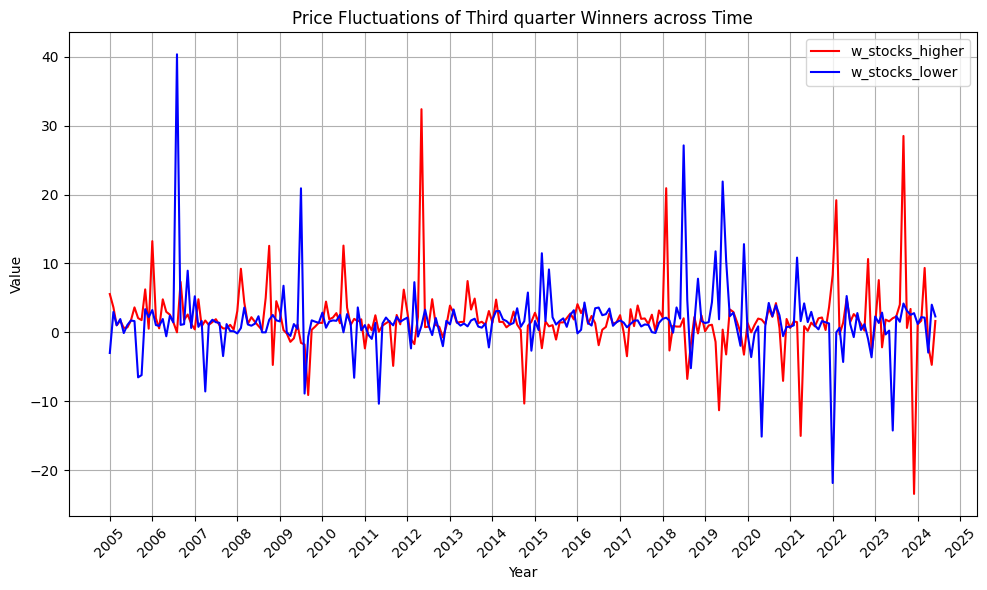

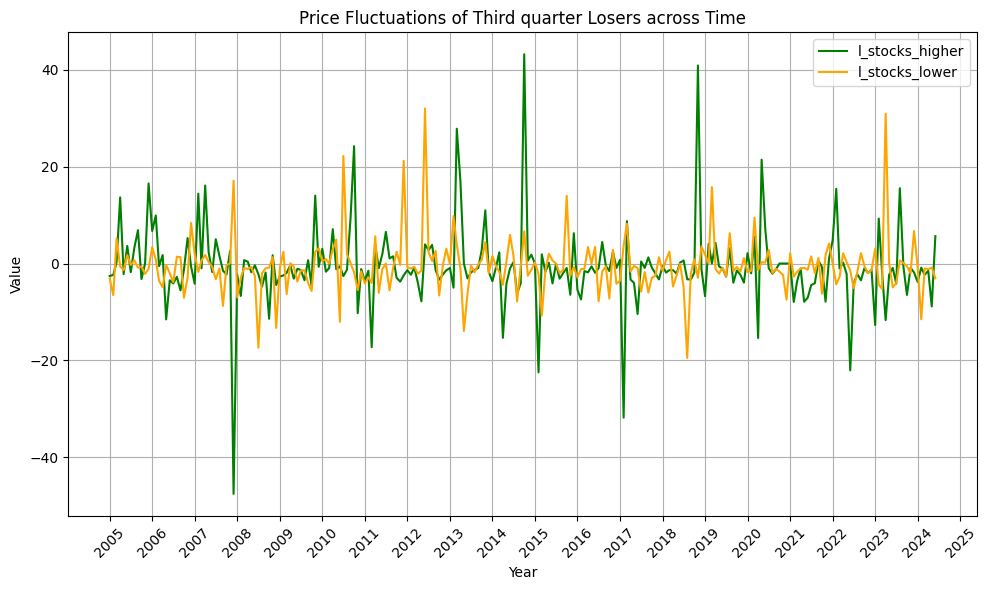

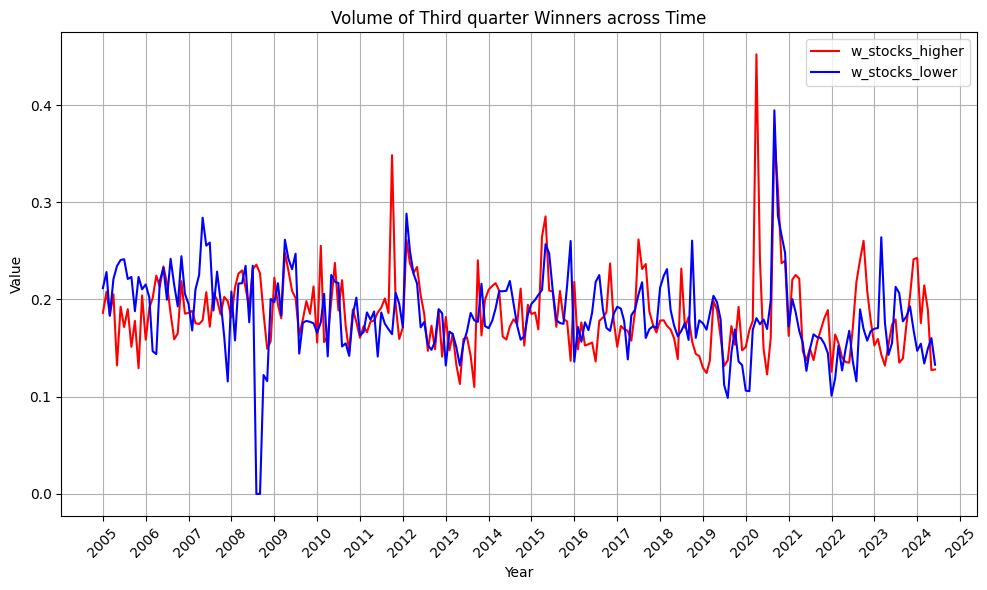

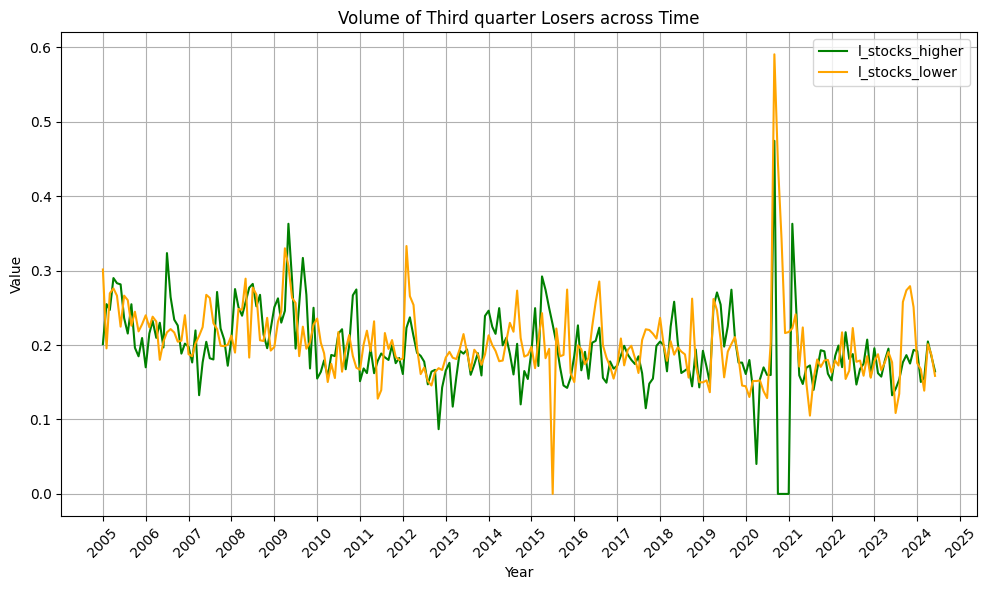

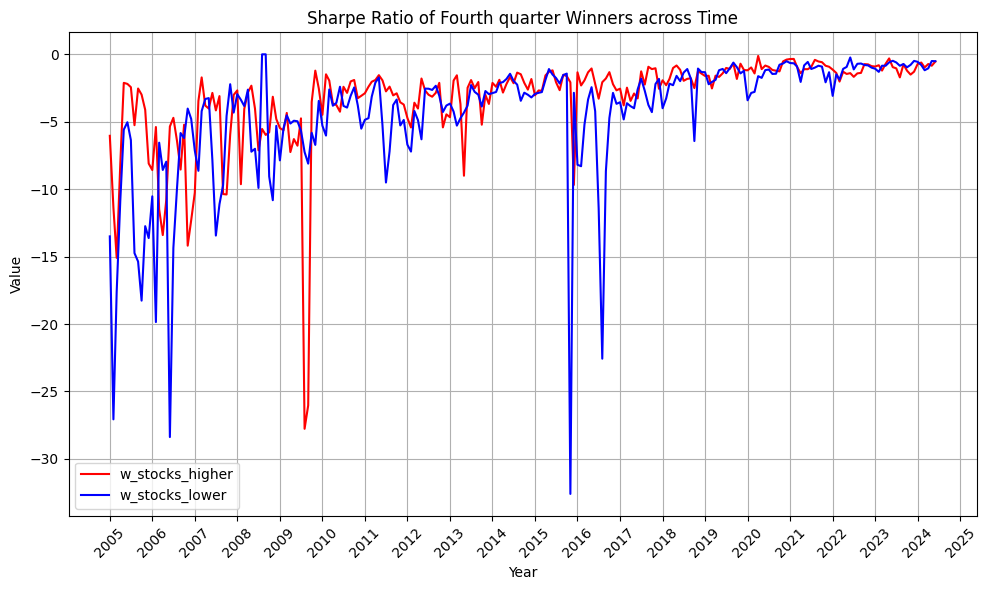

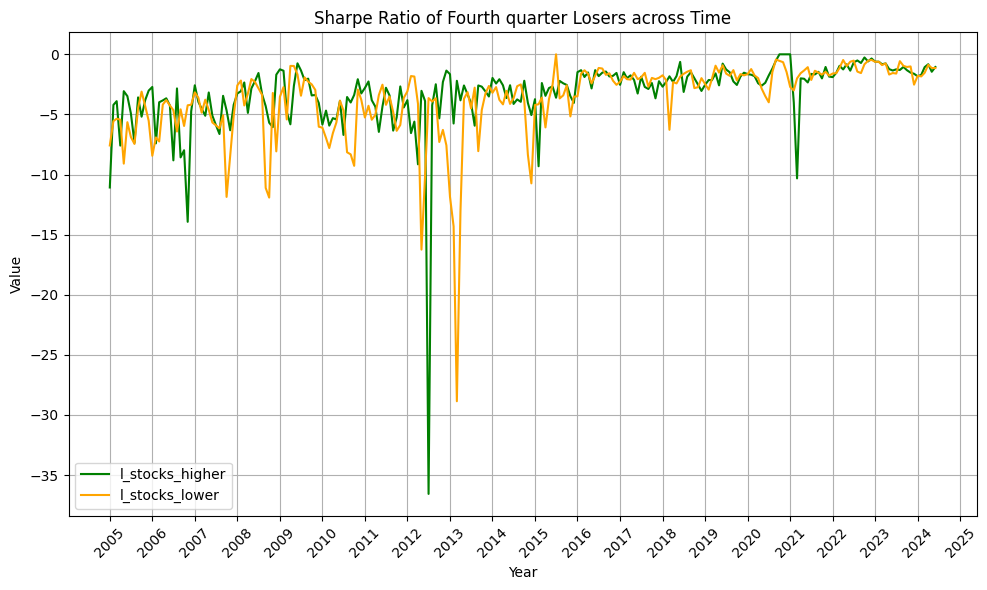

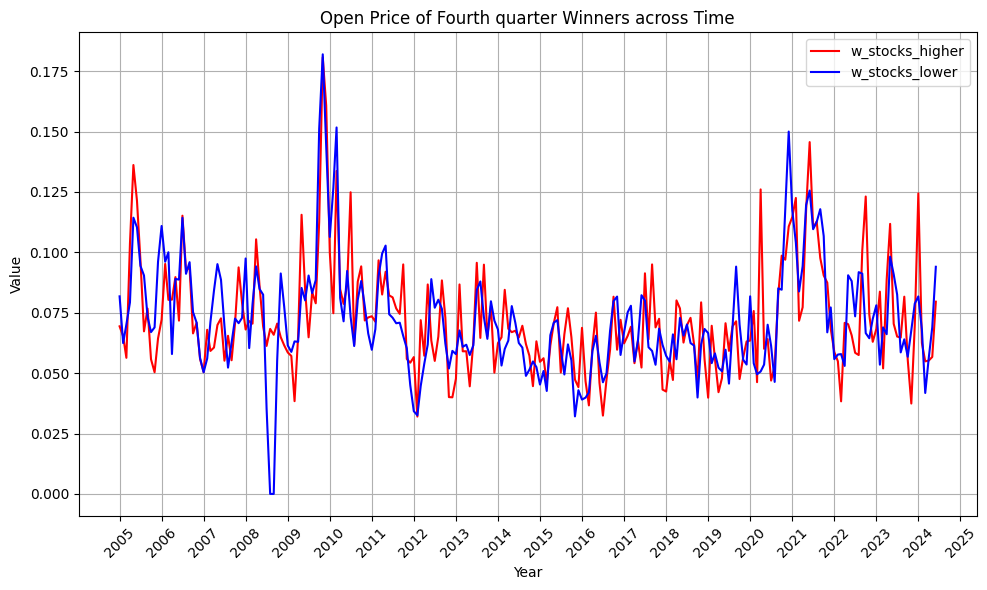

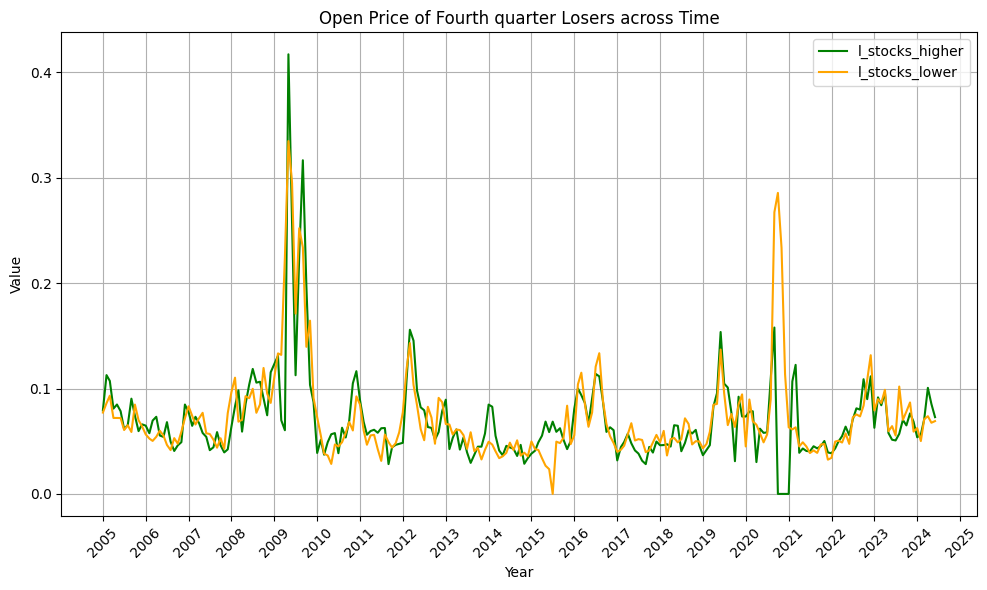

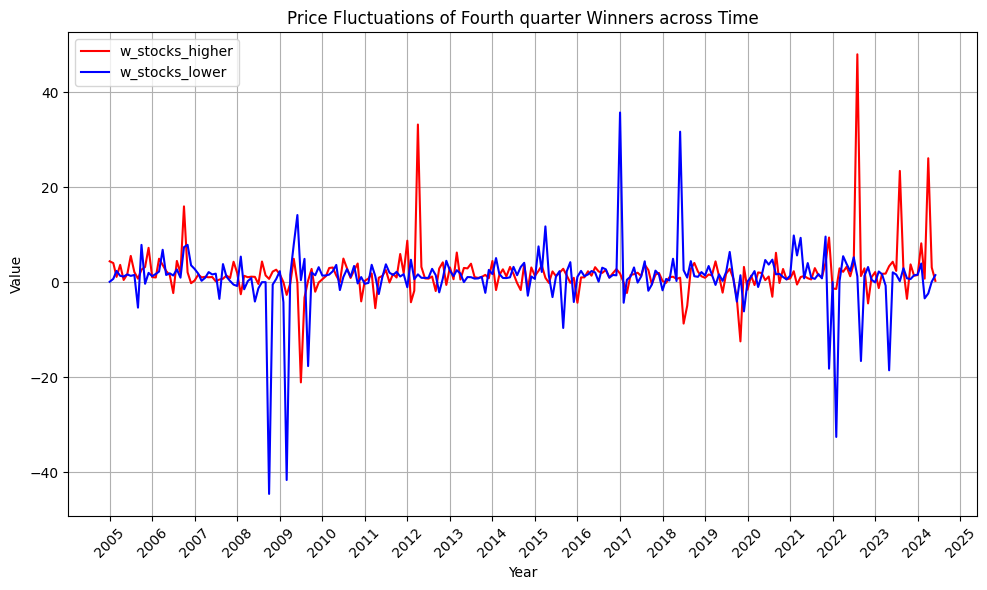

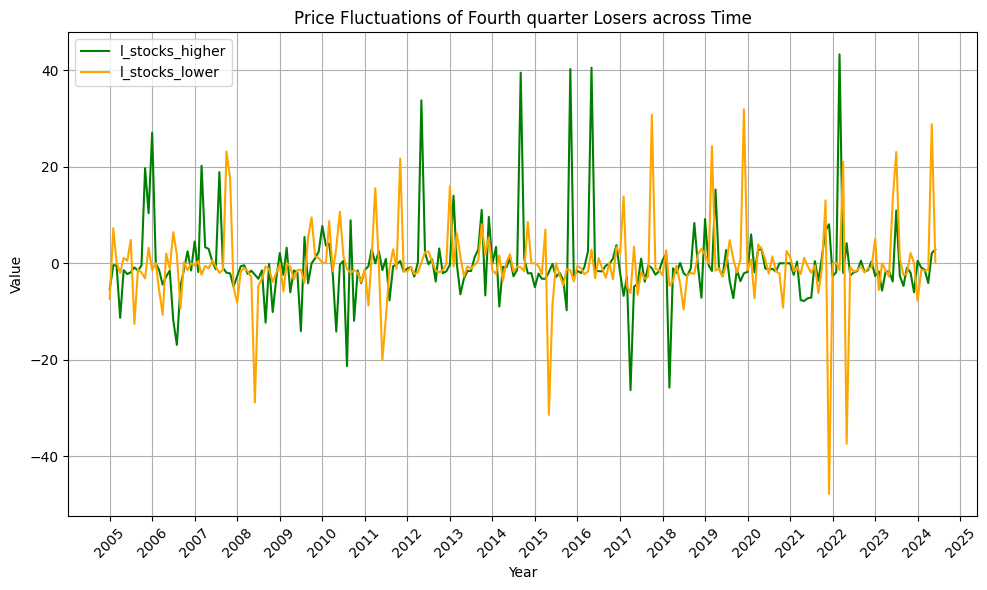

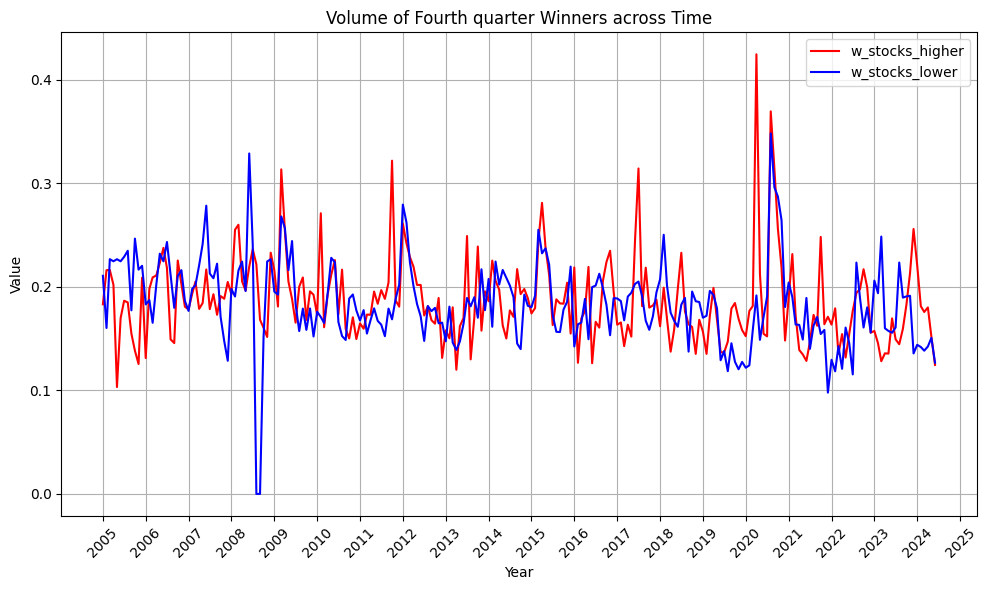

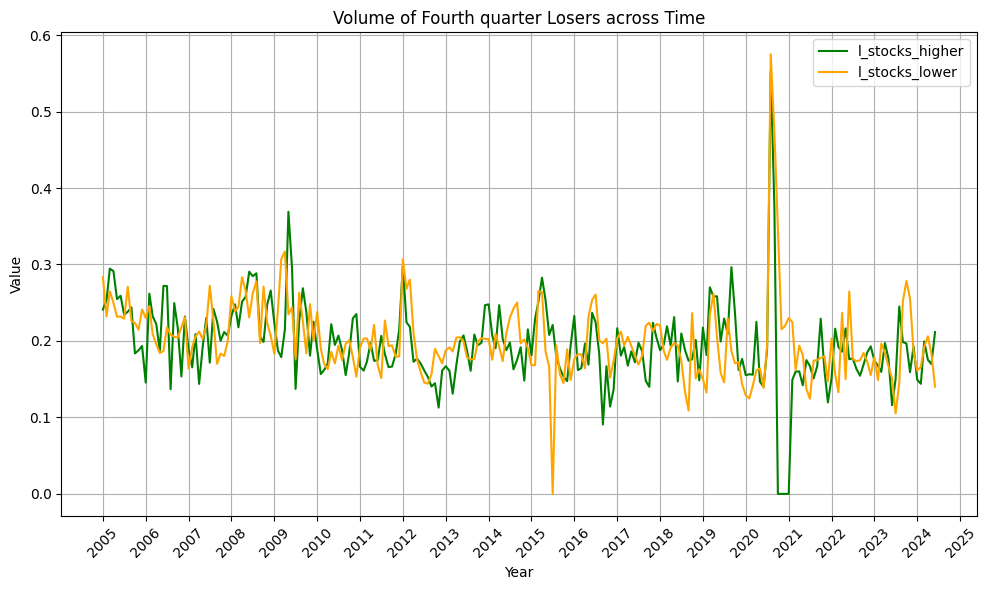

In [4]:
# Metrics to plot

metrics = results_dict['w_stocks_higher'].keys()
results_dict['date'] = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S%z') for date in results_dict['date']]

colors = [['red', 'blue'],['green', 'orange']]
stock_type_group = [['w_stocks_higher', 'w_stocks_lower'], ['l_stocks_higher', 'l_stocks_lower']]

for metric in metrics:
    
    # Plot each stock type
    for stock_type_group_ind in range(len(stock_type_group)):
        
        plt.figure(figsize=(10, 6))

        for stocks_type_i, stocks_type in enumerate(stock_type_group[stock_type_group_ind]):
            values = results_dict[stocks_type][metric]
            values = np.where(np.abs(values) < 50, values, 0) 
            
            # Plot
            plt.plot(results_dict['date'], values, label=stocks_type, color=colors[stock_type_group_ind][stocks_type_i])

        period_name, wl_name, metric_name = extract_period_name(metric, stock_type_group[stock_type_group_ind][0])
        fig_name = f'{metric_name} of {period_name} {wl_name} across Time'
        plt.title(fig_name)
        
        # Format x-axis to show years only
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        
        plt.xlabel('Year')
        plt.ylabel('Value')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()
        plt.tight_layout()
        image_path = os.path.join(IMG_DIR_LOC, f'{"_".join(fig_name.split())}.png')
        plt.savefig(image_path)  # Save the figure to a file
        plt.show()
